### What is ARIMA?
Autoregressive Integrated Moving Average (ARIMA) Model converts non-stationary data to stationary data before working on it. It is one of the most popular models to predict linear time series data.

ARIMA model has been used extensively in the field of finance and economics as it is known to be robust, efficient and has a strong potential for short-term share market prediction.

In [65]:
#pip install pmdarima

In [64]:
#pip install statsmodels

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
stock_data = pd.read_csv('TSLA.csv', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

In [3]:
stock_data = stock_data.drop(["Open","High", "Low", "Adj Close", "Volume"], axis = 1)

In [4]:
stock_data

,Close
Date,
2017-04-20,60.501999
2017-04-21,61.119999
2017-04-24,61.605999
2017-04-25,62.757999
2017-04-26,62.034000
...,...
2022-04-12,986.950012
2022-04-13,1022.369995
2022-04-14,985.000000


### Visualize the per day closing price of the stock.

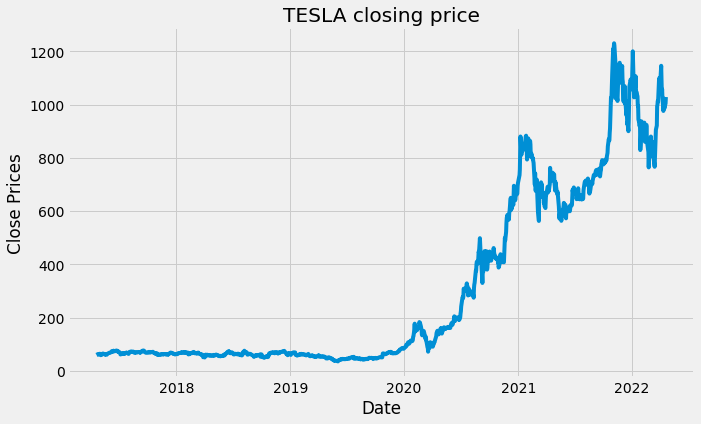

In [5]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('TESLA closing price')
plt.show()

In [6]:
df_close =stock_data['Close']

In [8]:
df_close

Date
2017-04-20      60.501999
2017-04-21      61.119999
2017-04-24      61.605999
2017-04-25      62.757999
2017-04-26      62.034000
                 ...     
2022-04-12     986.950012
2022-04-13    1022.369995
2022-04-14     985.000000
2022-04-18    1004.289978
2022-04-19    1028.150024
Name: Close, Length: 1259, dtype: float64

### We can also visualize the data in our series through a probability distribution too.

<AxesSubplot:ylabel='Density'>

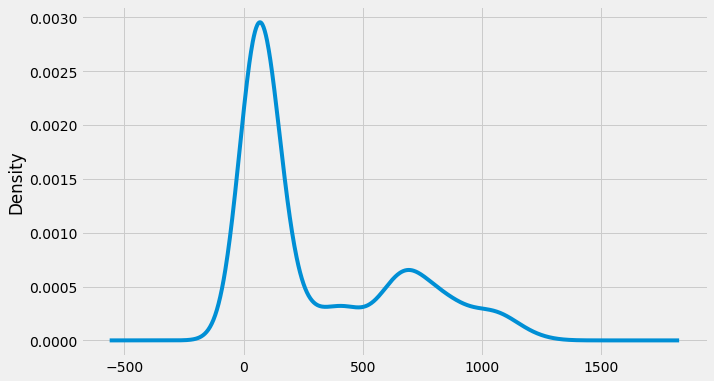

In [7]:
#Distribution of the dataset
df_close.plot(kind='kde')

##### Also, a given time series is thought to consist of three systematic components including level, trend, seasonality, and one non-systematic component called noise.

##### These components are defined as follows:

##### 1)Level: The average value in the series.

##### 2)Trend: The increasing or decreasing value in the series.

##### 3) Seasonality: The repeating short-term cycle in the series.

##### 4) Noise: The random variation in the series.

#### First, we need to check if a series is stationary or not because time series analysis only works with stationary data.

#### ADF (Augmented Dickey-Fuller) Test

#### The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

#### Null Hypothesis: The series has a unit root (value of a =1)

##### Alternate Hypothesis: The series has no unit root.

##### If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

##### If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

##### **So let's check for stationarity:

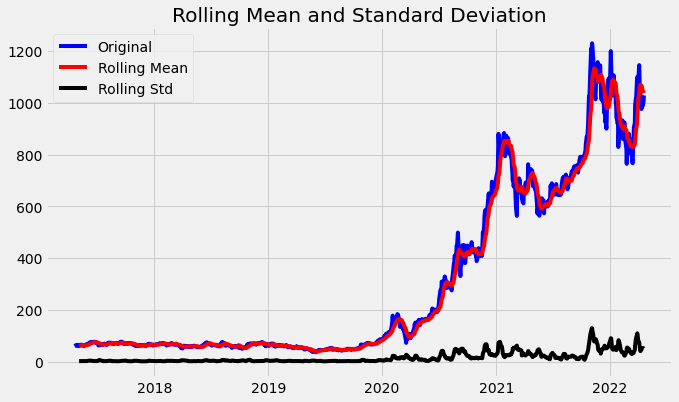

Results of dickey fuller test
Test Statistics                   0.278942
p-value                           0.976357
No. of lags used                 12.000000
Number of observations used    1246.000000
critical value (1%)              -3.435609
critical value (5%)              -2.863862
critical value (10%)             -2.568006
dtype: float64


In [9]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

#### Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary. We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

#### In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

#### So let us separate Trend and Seasonality from the time series.

<Figure size 720x432 with 0 Axes>

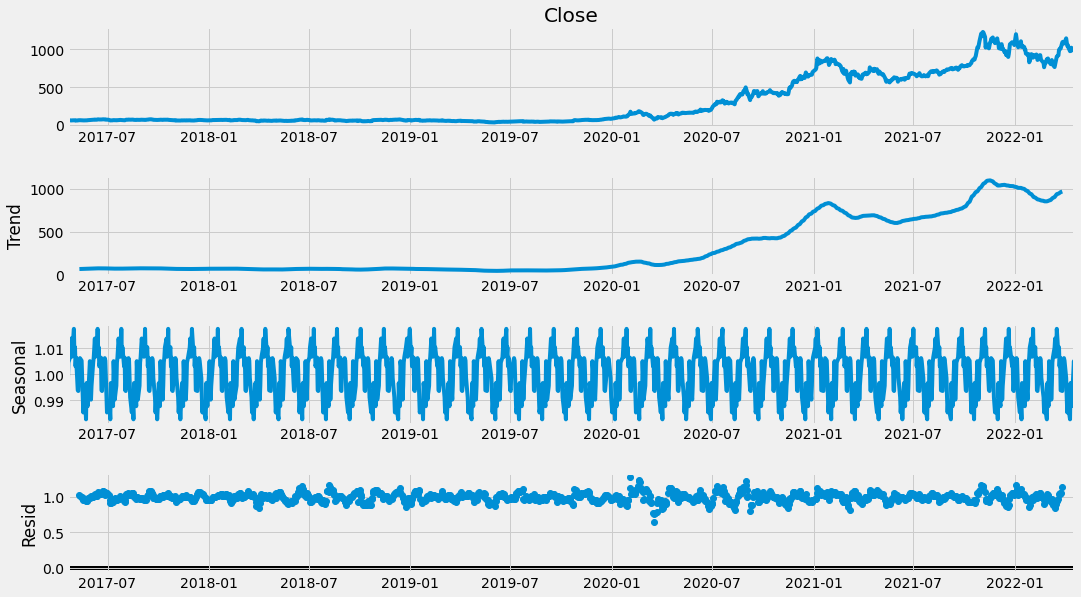

In [10]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

#### We start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series. A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


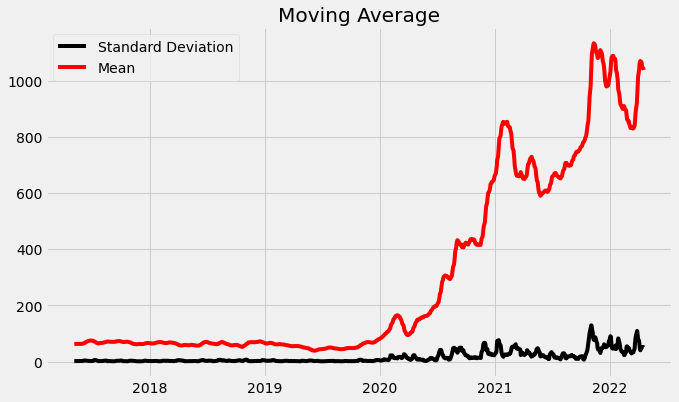

In [11]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
# df_log = np.log(df_close)
df_log = df_close
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

#### Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

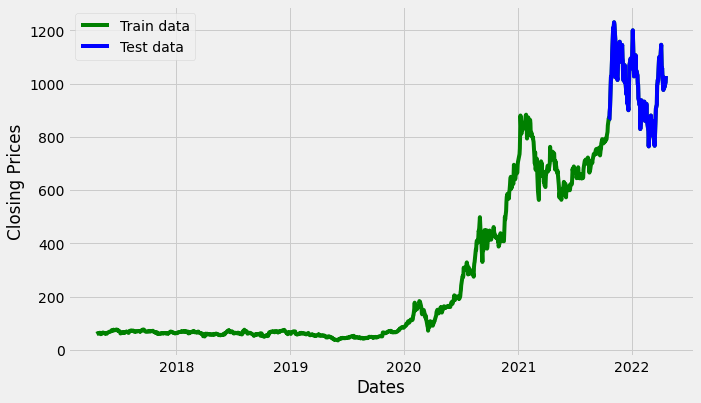

In [12]:
#split data into train and training set
train_data, test_data = stock_data[3:int(len(stock_data)*0.9)], stock_data[int(len(stock_data)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(stock_data['Close'], 'green', label='Train data')
plt.plot(test_data['Close'], 'blue', label='Test data')
plt.legend()

In [14]:
test_data

,Close
Date,
2021-10-19,864.270020
2021-10-20,865.799988
2021-10-21,894.000000
2021-10-22,909.679993
2021-10-25,1024.859985
...,...
2022-04-12,986.950012
2022-04-13,1022.369995
2022-04-14,985.000000


#### Auto ARIMA: Automatically discover the optimal order for an ARIMA model.
#### The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.

#### The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In [27]:
# model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
#                       test='adf',       # use adftest to find optimal 'd'
#                       max_p=3, max_q=3, # maximum p and q
#                       m=1,              # frequency of series
#                       d=None,           # let model determine 'd'
#                       seasonal=False,   # No Seasonality
#                       start_P=0, 
#                       D=0, 
#                       trace=True,
#                       error_action='ignore',  
#                       suppress_warnings=True, 
#                       stepwise=True)


In [28]:
# print(model_autoARIMA.summary())
# model_autoARIMA.plot_diagnostics(figsize=(15,8))
# plt.show()

#### from the AutoARIMA Model output : **Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept**

#### **Assuming the Auto ARIMA model provided the value of p,d, and q as 0, 1 and 0 respectively.**

In [15]:
print(train_data)

                 Close
Date                  
2017-04-25   62.757999
2017-04-26   62.034000
2017-04-27   61.726002
2017-04-28   62.813999
2017-05-01   64.566002
...                ...
2021-10-12  805.719971
2021-10-13  811.080017
2021-10-14  818.320007
2021-10-15  843.030029
2021-10-18  870.109985

[1130 rows x 1 columns]


In [16]:
type(train_data)

pandas.core.frame.DataFrame

In [17]:
training_data = train_data['Close'].values
test_data = test_data['Close'].values

In [117]:
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)

In [118]:
N_test_observations

126

In [119]:
for time_point in range(N_test_observations):
    model = SARIMAX(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)

In [120]:
model_predictions

[870.109985,
 864.2700200000002,
 865.799988,
 894.0,
 909.679993,
 1024.859985,
 1018.4299929999999,
 1037.859985,
 1077.040039,
 1114.0,
 1208.589966,
 1172.0,
 1213.859985,
 1229.910034,
 1222.089966,
 1162.939941,
 1023.5,
 1067.949951,
 1063.51001,
 1033.420044,
 1013.3900149999998,
 1054.72998,
 1089.01001,
 1096.380005,
 1137.060059,
 1156.869995,
 1109.030029,
 1116.0,
 1081.920044,
 1136.98999,
 1144.76001,
 1095.0,
 1084.599976,
 1014.9699709999999,
 1009.01001,
 1051.75,
 1068.959961,
 1003.7999880000001,
 1017.030029,
 966.409973,
 958.51001,
 975.98999,
 926.919983,
 932.570007,
 899.940002,
 938.530029,
 1008.869995,
 1067.0,
 1093.939941,
 1088.469971,
 1086.189941,
 1070.339966,
 1056.780029,
 1199.780029,
 1149.589966,
 1088.119995,
 1064.699951,
 1026.959961,
 1058.119995,
 1064.400024,
 1106.219971,
 1031.560059,
 1049.609985,
 1030.51001,
 995.650024,
 996.27002,
 943.900024,
 930.0,
 918.400024,
 937.409973,
 829.099976,
 846.349976,
 936.719971,
 931.25,
 905.6599

In [121]:
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 1771.8769627082404


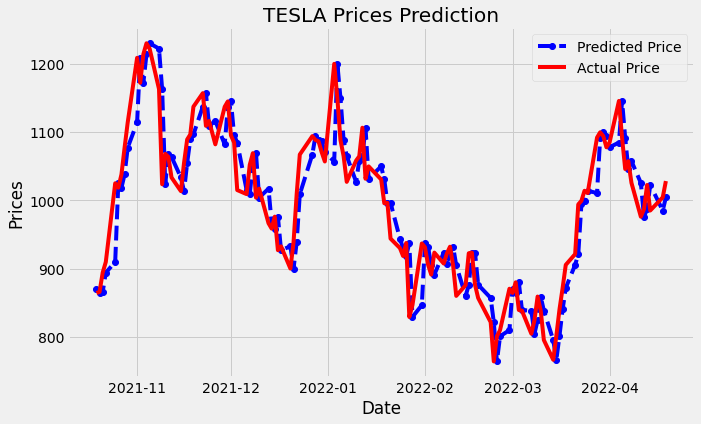

In [21]:
test_set_range = stock_data[int(len(stock_data)*0.9):].index
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('TESLA Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
# plt.xticks(np.arange(881,1259,50), stock_data.Date[881:1259:50])
plt.legend()
plt.show()

### ARIMA model performance on the test set shows appreciable results. This model offers a good prediction accuracy and to be relatively fast compared to other alternatives

In [22]:
# report performance
mse = mean_squared_error(test_data, model_predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, model_predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data,  model_predictions))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs( model_predictions - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 1771.8769627082404
MAE: 32.495230484127
RMSE: 42.093668914793355
MAPE: 0.032807744497038306


#### MAPE of 3.28% means that our model is about 96.72% accurate 

## Training a model on the complete data

In [102]:
import pmdarima as pm

In [103]:
data = stock_data
model_data = data['Close'].values

In [104]:
data

,Close
Date,
2017-04-20,60.501999
2017-04-21,61.119999
2017-04-24,61.605999
2017-04-25,62.757999
2017-04-26,62.034000
...,...
2022-04-12,986.950012
2022-04-13,1022.369995
2022-04-14,985.000000


In [122]:
data.to_csv("data.csv")

In [105]:
model_arima = pm.arima.auto_arima(data, seasonal=True, m=12,error_action='ignore',
                             suppress_warnings=True,)

In [106]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 1259
Model:             SARIMAX(2, 1, 2)x(2, 0, [], 12)   Log Likelihood               -5359.212
Date:                             Thu, 21 Apr 2022   AIC                          10734.423
Time:                                     00:02:57   BIC                          10775.522
Sample:                                          0   HQIC                         10749.869
                                            - 1259                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      3.2742      1.187      2.758      0.006       0.947       5.601
ar.L1         -0.2844      0.012    -24.281      0.000      -0.307      -0.261
ar.L2         -0.9841      0.011    -93.616      0.000      -1.005      -0.963
ma.L1          0.2528      0.014     17.800      0.000       0.225       0.281
ma.L2          0.9782      0.014     70.733      0.000       0.951       1.005
ar.S.L12       0.0861      0.020      4.227      0.000       0.046       0.126
ar.S.L24       0.1898      0.016     11.769      0.000       0.158       0.221
sigma2       304.1440      5.093     59.721      0.000     294.162     314.126
===================================================================================
Ljung-Box (L1) (Q):                   1.47   Jarque-Bera (JB):             11060.01
Prob(Q):                              0.23   Prob(JB):                         0.00
Heteroskedasticity (H):             136.14   Skew:                             0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [107]:
import pickle
pickle.dump(model_arima, open('model_arima.pkl','wb'))

In [110]:
pred = model_arima.predict(n_periods = 30)

In [111]:
pred

array([1040.22763189, 1040.48672505, 1044.481752  , 1056.9506501 ,
       1069.00945056, 1058.12074602, 1065.23757491, 1075.38029648,
       1085.88368719, 1080.00886892, 1092.88700675, 1095.67263374,
       1088.14164255, 1102.02199499, 1104.44057614, 1094.36819509,
       1089.41739682, 1090.52134274, 1090.75065546, 1086.48272882,
       1090.56274049, 1094.36545521, 1102.65686548, 1098.47898095,
       1102.47453077, 1115.12734413, 1113.80898295, 1108.00522172,
       1117.4661468 , 1123.79416002])

In [112]:
lst = []
for i in range(len(data['Close'].tolist())):
         lst.append(i)
close_list = pd.DataFrame(
    {'Date': lst,
     'Close': data['Close'].tolist(),
    })
close_list = close_list.set_index('Date')
plst = []
for i in range(len(pred)):
         plst.append(len(lst)+i)
pred_list = pd.DataFrame(
    {'Date': plst,
     'Close': pred,
    })
pred_list = pred_list.set_index('Date')


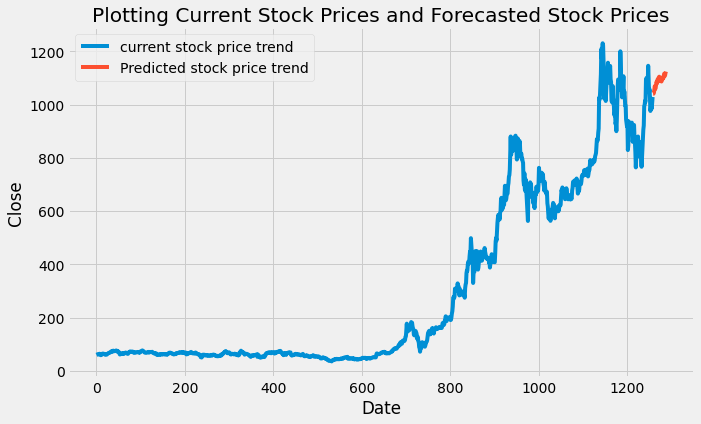

In [113]:

plt.plot(close_list, label ='current stock price trend')
plt.plot(pred_list, label='Predicted stock price trend')
plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Plotting Current Stock Prices and Forecasted Stock Prices')
plt.legend()
plt.show()

In [40]:
history_model_data

[60.501999,
 61.119999,
 61.605999,
 62.757999,
 62.034,
 61.726002,
 62.813999,
 64.566002,
 63.778,
 62.203999,
 59.091999,
 61.669998,
 61.438,
 64.251999,
 65.043999,
 64.620003,
 64.961998,
 63.175999,
 63.402,
 61.222,
 62.612,
 62.166,
 62.07,
 60.771999,
 62.043999,
 63.366001,
 65.028,
 67.019997,
 68.202003,
 68.073997,
 67.970001,
 69.463997,
 70.57,
 71.93,
 74.0,
 71.463997,
 71.802002,
 75.190002,
 76.132004,
 75.068001,
 74.279999,
 73.959999,
 74.447998,
 75.279999,
 76.522003,
 76.690002,
 75.498001,
 72.473999,
 74.248001,
 72.150002,
 72.321999,
 70.524002,
 65.417999,
 61.765999,
 62.644001,
 63.209999,
 65.444,
 65.903999,
 64.681999,
 65.556,
 63.914001,
 65.648003,
 65.052002,
 65.984001,
 65.68,
 68.503998,
 67.919998,
 68.769997,
 66.891998,
 67.014,
 64.694,
 63.914001,
 65.178001,
 69.417999,
 71.382004,
 71.033997,
 73.043999,
 72.706001,
 71.080002,
 71.573997,
 72.760002,
 72.466003,
 72.582001,
 70.384003,
 69.491997,
 67.571999,
 68.269997,
 70.554001,
 

In [41]:
model_final = SARIMAX(history_model_data, order=(0,1,0))
model_final_fit = model_final.fit(disp=0)
output_final = model_final_fit.forecast(100)


In [42]:
output_final

array([1028.150024, 1028.150024, 1028.150024, 1028.150024, 1028.150024,
       1028.150024, 1028.150024, 1028.150024, 1028.150024, 1028.150024,
       1028.150024, 1028.150024, 1028.150024, 1028.150024, 1028.150024,
       1028.150024, 1028.150024, 1028.150024, 1028.150024, 1028.150024,
       1028.150024, 1028.150024, 1028.150024, 1028.150024, 1028.150024,
       1028.150024, 1028.150024, 1028.150024, 1028.150024, 1028.150024,
       1028.150024, 1028.150024, 1028.150024, 1028.150024, 1028.150024,
       1028.150024, 1028.150024, 1028.150024, 1028.150024, 1028.150024,
       1028.150024, 1028.150024, 1028.150024, 1028.150024, 1028.150024,
       1028.150024, 1028.150024, 1028.150024, 1028.150024, 1028.150024,
       1028.150024, 1028.150024, 1028.150024, 1028.150024, 1028.150024,
       1028.150024, 1028.150024, 1028.150024, 1028.150024, 1028.150024,
       1028.150024, 1028.150024, 1028.150024, 1028.150024, 1028.150024,
       1028.150024, 1028.150024, 1028.150024, 1028.150024, 1028.

In [34]:
for time_point_final in range(final_N_test_observations):
    model_final = SARIMAX(history_model_data, order=(0,1,0))
    model_final_fit = model_final.fit(disp=0)
    output_final = model_final_fit.forecast()
    yhat_final = output_final[0]
    final_model_predictions.append(yhat_final)
    # true_test_value = test_data[time_point]
    history_model_data.append(yhat_final)


In [35]:
final_model_predictions

[1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.150024,
 1028.

In [31]:
    yhat = output[0]

In [32]:
yhat

1004.289978